# **PSET 3**

 These are some of the libraries/modules you will require for this homework.

In [1]:
# Install OpenCV version 4.5.1.48 as it includes SIFT.
# %pip install opencv-contrib-python==4.5.1.48

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import copy
import os
import random

import numpy as np
import scipy
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

These are some functions which will be useful throughout the homework for visualizations.

In [3]:
def display_color(x: np.array, normalized:bool = False):
    plt.figure(figsize=(10,10))
    if not normalized:
        plt.imshow(x,vmin=0,vmax=1)
    else:
        plt.imshow(x/x.max(),vmin=0,vmax=1)
    return plt

In [4]:
def plot_correspondences(image1, image2, correspondences, color):
    image = np.concatenate((image1, image2), axis=1)
    for correspondence in correspondences:
        point1, point2 = correspondence
        point1 = (int(round(point1[0])), int(round(point1[1])))
        point2 = (int(round(point2[0])), int(round(point2[1])))
        cv2.circle(image, point1, 10, color, 2, cv2.LINE_AA)
        cv2.circle(image, tuple([point2[0] + image1.shape[1], point2[1]]), 10, 
                   color, 2, cv2.LINE_AA)
        cv2.line(image, point1, tuple([point2[0] + image1.shape[1], point2[1]]), 
                 color, 2)
    plot = display_color(image)
    return plot

# Question 3

### Image Stitching

In this question, you will be stitching together two images of the same scene (images assumed to be in left to right order) taken from different camera viewpoints to form a panorama of the scene. This task will require implementing a pipeline with the following steps:

1. Extract SIFT keypoints and descriptors from each image and propose possible correspondences by matching SIFT descriptors between the two images. Note that this step outputs some false correspondences, which will be pruned in the next step.
2. Estimate the homography between the two images using the following RANSAC loop:

```
For N iterations:
    i. Get random subset of correspondences.
    ii. Compute the homography H using homogeneous direct linear transform (DLT) applied to the random subset of correspondences.
    iii. Count the number of inliers, where inliers are the correspondences (in the whole set of correspondences) that the homography 
    fits well (using Euclidean distance as the error metric).
    iv. Keep the homography H with the largest number of inliers and H's corresponding set of inliers.
```

3. Recompute the homography H using the set of inliers from step 2.
4. Use the homographies obtained from step 3 to stitch together the images to form a panorama.

Load the two images to be stitched together.

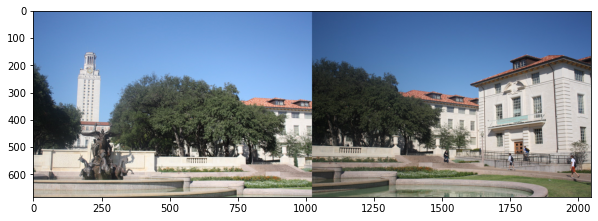

In [5]:
image1 = np.asarray(Image.open('Data/Problem_3/uttower_left.jpg'))
image2 = np.asarray(Image.open('Data/Problem_3/uttower_right.jpg'))
plot = display_color(np.concatenate((image1, image2), axis=1))

#### **Answer 3.1**

The first step of image stitching is to obtain SIFT keypoints and descriptors for each image. Complete the function ```run_sift(image, num_features)``` that returns the SIFT keypoints and descriptors for a color image ```image```; ```num_features``` is a parameter that limits the number of SIFT keypoints and descriptors the function should return. Note that you will need to convert the image to grayscale before running SIFT. *Hint*: OpenCV has functions to convert an RGB image to grayscale and to compute SIFT keypoints and descriptors given a grayscale image.

Copy paste your solution in the cell below on Overleaf for Question 3.1.

In [6]:
# Write your code in this cell.

def run_sift(image, num_features):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(num_features)
    keypoints, descriptors = sift.detectAndCompute(grayImage,None)
    return keypoints, descriptors

#### **Answer 3.2**

After computing the SIFT keypoints and descriptors, you will then need to match SIFT descriptors between the two images to obtain a set of possible correspondences. To obtain these correspondences, you should follow the steps below as proposed in the SIFT paper (Lowe 2004):

```
For every keypoint kp in the first image, 

1. Find the two keypoints kp1, kp2 in the second image with descriptors des1, des2 that are closest and second closest, respectively, 
to the descriptor des of the first image's keypoint. The distance metric is Euclidean distance d(x, y).
2. Add (kp, kp1) as a possible correspondence if d(des, des1) < ratio * d(des, des2), where ratio is a parameter of the algorithm. 
The idea here is that you want the descriptor des1 in the second image to be much closer to the descriptor des in the first image 
than any other descriptor in the second image.
```
Complete the function ```find_sift_correspondences(kp1, des1, kp2, des2, ratio)``` that returns a list of possible correspondences given SIFT keypoints ```kp1, kp2``` and descriptors ```des1, des2``` from the two images and the parameter ```ratio```.

Copy paste your solution in the cell below on Overleaf for Question 3.2.

In [7]:
# Write your code in this cell.

def find_sift_correspondences(kp1, des1, kp2, des2, ratio):
    ret = list()
    for keypoint, descriptor in zip(kp1, des1):
        closest_kp, closest_dist = 0, float('inf')
        second_closest_kp, second_closest_dist = 0, float('inf')
        for kp, des in zip(kp2, des2):
            dist = np.linalg.norm(descriptor - des)
            if dist < closest_dist:
                second_closest_dist = closest_dist
                closest_dist = dist
                second_closest_kp = closest_kp
                closest_kp = kp
            elif dist < second_closest_dist:
                second_closest_dist = dist
                second_closest_kp = kp
        if closest_dist < ratio * second_closest_dist:
            ret.append(((keypoint.pt[0], keypoint.pt[1]), (closest_kp.pt[0], closest_kp.pt[1])))
    return np.array(ret)

#### **Answer 3.3**

Now that you have computed the possible correspondences, you can now visualize them. You should observe that there are many correspondences, some of which are quite noisy (you will observe this more clearly after implementing RANSAC).

Upload the saved image on Overleaf for Question 3.3.

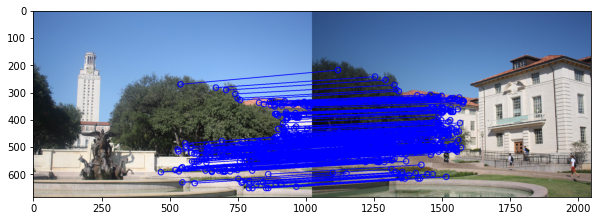

In [8]:
kp1, des1 = run_sift(image1, 2000)
kp2, des2 = run_sift(image2, 2000)
correspondences = find_sift_correspondences(kp1, des1, kp2, des2, 0.6)
plot = plot_correspondences(image1, image2, correspondences, (0, 0, 255))
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/question_3_3.pdf', format='pdf', bbox_inches='tight')

#### **Answer 3.4**

After obtaining possible correspondences, you will need to use the RANSAC loop to prune the outlier correspondences. You will implement the RANSAC loop in parts. The first part is to compute the homography given a list of correspondences. Complete the function ```compute_homography(correspondences)``` that computes a homography matrix $H$ using homogeneous direct linear transform (DLT) given a list of correspondences (in heterogeneous coordinates).

Copy paste your solution in the cell below on Overleaf for Question 3.4.

In [9]:
# Write your code in this cell.

def compute_homography(correspondences):
    A = []
    for corr in correspondences:
        a1 = np.array([-corr[0][0], -corr[0][1], -1, 0, 0, 0, corr[0][0] * corr[1][0], corr[0][1] * corr[1][0], corr[1][0]])
        a2 = np.array([0, 0, 0, -corr[0][0], -corr[0][1], -1, corr[0][0] * corr[1][1], corr[0][1] * corr[1][1], corr[1][1]])
        A.append(a1)
        A.append(a2)
        
    A = np.array(A)
    [U, S, Vt] = np.linalg.svd(A)
    homography = Vt[8].reshape(3, 3)
    return homography / homography[-1][-1]

#### **Answer 3.5**

In addition to computing a homography matrix $H$ given a list of correspondences, it is also useful to apply a homography to warp a list of 2D points. Complete the function ```apply_homography(points, homography)``` that applies a homography to warp a list of 2D points given in heterogeneous coordinates. The function should return a list of 2D points, also in heterogeneous coordinates.

*Hint*: You should convert the input 2D points into homogeneous coordinates before applying the homography. After applying the homography, you get the output 2D points in homogeneous coordinates, so you have to convert the output points back into heterogeneous coordinates.

Copy paste your solution in the cell below on Overleaf for Question 3.5.

In [10]:
# Write your code in this cell.

def apply_homography(points, homography):
    points = np.array([points[0], points[1], 1])
    p = homography.dot(points)  
    w = p[2]
    x = p[0] / w
    y = p[1] / w
    return np.array([x, y])

#### **Answer 3.6**

Another part of the RANSAC loop is determining the inliers, where inliers are the correspondences that the homography fits within a Euclidean distance threshold. Complete the function ```compute_inliers(homography, correspondences, threshold)``` that returns the list of inliers and the list of outliers given a homography matrix, a set of potential correspondences, and a distance threshold.

Copy paste your solution in the cell below on Overleaf for Question 3.6.

In [11]:
# Write your code in this cell.

def compute_inliers(homography, correspondences, threshold):
    inliers = list()
    outliers = list()
    for correspondence in correspondences:
        projected = apply_homography(correspondence[0], homography)
        distance = np.sqrt((projected[0] - correspondence[1][0]) ** 2 + (projected[1] - correspondence[1][1]) ** 2)
        if distance < threshold:
            inliers.append(correspondence)
        else:
            outliers.append(correspondence)
    return np.array(inliers), np.array(outliers)

#### **Answer 3.7**

Now that you have implemented functions to compute a homography matrix and its inliers, you can now implement the RANSAC loop. Complete the function ```ransac(correspondences, num_iterations, num_sampled_points, threshold)```, which runs the RANSAC loop to return a homography matrix with its corresponding sets of inliers and outliers. The parameters to the function are the set of possible correspondences, the number of iterations, the number of correspondences to sample for each iteration, and the inliers distance threshold.

Copy paste your solution in the cell below on Overleaf for Question 3.7.

In [12]:
# Write your code in this cell.

def ransac(correspondences, num_iterations, num_sampled_points, threshold):
    max_len = 0
    H = []
    for i in range(num_iterations):
        sampled_correspondences = list()
        for j in range(num_sampled_points):
            random_integer = np.random.randint(0, len(correspondences) - 1)
            sampled_correspondences.append(correspondences[random_integer])
        
        sampled_correspondences = np.array(sampled_correspondences)
        homography = compute_homography(sampled_correspondences)
        inliers, outliers = compute_inliers(homography, correspondences, threshold)
        if len(inliers) > max_len:
            max_len = len(inliers)
            inliers_best = inliers
            outliers_best = outliers
            H = homography
    homography_best = compute_homography(inliers_best)
    return homography_best, inliers, outliers

#### **Answer 3.8**

You will now visualize the inlier (first image in green) and outlier (second image in red) correspondences returned by RANSAC. Note that some of the outliers are quite noisy.

Execute the cell below and copy the saved images on Overleaf for Question 3.8.

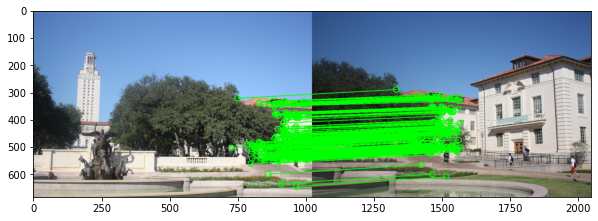

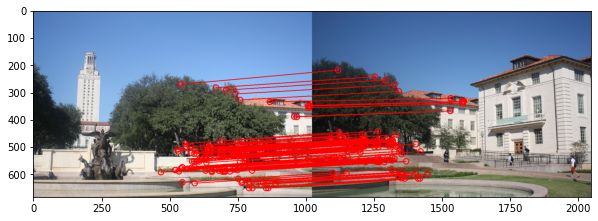

In [13]:
_, inliers, outliers = ransac(correspondences, 50, 6, 3)
inliers_plot = plot_correspondences(image1, image2, inliers, (0, 255, 0))
inliers_plot.savefig('Data/Solutions/question_3_8_inliers.pdf', format='pdf', bbox_inches='tight')
outliers_plot = plot_correspondences(image1, image2, outliers, (255, 0, 0))
outliers_plot.savefig('Data/Solutions/question_3_8_outliers.pdf', format='pdf', bbox_inches='tight')

#### **Answer 3.9**

The final portion that needs to be implemented is the actual stitching of the two images given the homography $H$ from the first image to the second image. For the stitching process, you should apply inverse warping to warp the second image to the viewpoint of the first image. The inverse warping works as follows:
1. Find where pixels ```p1``` in the first image (output image) are warped to in the second image (input image) when applying the homography $H$. Note that the homography $H$ itself is the inverse transform as you are currently trying to warp the second image to the first image, which would use homography $H^{-1}$. Let ```p2``` be the corresponding pixel location in the second image.
2. Assuming that ```p2``` is in the second image, the pixel locations ```p2``` may not be integer locations. Apply bilinear interpolation to compute the pixel value of the second image at location ```p2```.

As bilinear interpolation is needed for the inverse warping, complete the function ```interpolate(image, loc)``` that implements bilinear interpolation to compute the pixel value in the image corresponding to a pixel location. 

Bilinear interpolation works as follows; for a given location $(x + \Delta x, y + \Delta y)$, where $x, y$ are integers and $0 \leq \Delta x, \Delta y < 1$, we consider the four neighboring integer pixel locations $(x, y), (x + 1, y), (x, y + 1), (x + 1, y + 1)$ and then perform multiple linear interpolations (it may help to take a look at lecture 8 slide 68 for some diagrams):

1. Compute pixel value $I(x + \Delta x, y)$: $I(x + \Delta x, y) = I(x, y) (1 - \Delta x) + I(x + 1, y) \Delta x $.
2. Compute pixel value $I(x + \Delta x, y + 1)$: $I(x + \Delta x, y + 1) = I(x, y + 1) (1 - \Delta x) + I(x + 1, y + 1) \Delta x $.
3. Compute pixel value $I(x + \Delta x, y + \Delta y)$: $I(x + \Delta x, y + \Delta y) = I(x + \Delta x, y) (1 - \Delta y) + I(x + \Delta x, y + 1) \Delta y$.

Substituting the first two steps into the last step, the following formula for bilinear interpolation is obtained:

$I(x + \Delta x, y + \Delta y) = I(x, y)(1 - \Delta x)(1 - \Delta y) + I(x + 1, y)\Delta x(1 - \Delta y) + I(x, y + 1)(1 - \Delta x)\Delta y + I(x + 1, y + 1)\Delta x \Delta y$.

Copy paste your solution in the cell below on Overleaf for Question 3.9.

In [14]:
# Write your code in this cell.

def interpolate(image, loc):
    x = loc[0]
    y = loc[1]
    x_floor = np.floor(x).astype(int)
    y_floor = np.floor(y).astype(int)
    delta_x = x - x_floor
    delta_y = y - y_floor
    x_delta_x_y = image[x_floor, y_floor] * (1.0 - delta_x) + image[x_floor + 1, y_floor] * delta_x
    x_delta_x_y_1 = image[x_floor, y_floor + 1] * (1.0 - delta_x) + image[x_floor + 1, y_floor + 1] * delta_x
    x_delta_x_y_delta_y = x_delta_x_y * (1.0 - delta_y) + x_delta_x_y_1 * delta_y
    return x_delta_x_y_delta_y

#### **Answer 3.10**

Now that you have implemented bilinear interpolation, you can implement a function to actually stitch the two images together. Complete the function ```stitch_image_given_H(image1, image2, homography)``` that stitches ```image1``` and ```image2``` together and returns the stitched image given a homography matrix from ```image1``` to ```image2```. This function should apply inverse warping as described above. For this function, you can assume that ```image1``` is to the left of ```image2```; if a pixel location in the stitched image belongs to both images, you can average the corresponding pixel values from both images.

Copy paste your solution in the cell below on Overleaf for Question 3.10.

In [15]:
# Write your code in this cell.

def stitch_image_given_H(image1, image2, homography):
    m1, n1, _ = image1.shape
    m2, n2, _ = image2.shape
    image = np.zeros((m1, n1 + n2, 3), np.float32)
    for y in range(m1):
        for x in range(n1 + n2):
            x_transformed, y_transformed = apply_homography((x, y), homography)
            if x_transformed < 0 or y_transformed < 0 or x_transformed > n2 - 1 or y_transformed > m2 - 1:
                continue
            image[y][x] = (interpolate(image2, (y_transformed, x_transformed)))
    stitched_image = np.copy(image)
    for y in range(m1):
        for x in range(n1):
            if not any(stitched_image[y][x]):
                stitched_image[y][x] = image1[y][x]
    return stitched_image

#### **Answer 3.11**

Now, you have implemented all the parts of the image stitching pipeline. Put it all together and complete the function ```stitch_image(image1, image2, num_features, sift_ratio, ransac_iter, ransac_sampled_points, inlier_threshold, use_ransac)``` that stitches two images together given various parameters of the algorithm (number of SIFT features, ratio for obtaining initial SIFT correspondences, RANSAC parameters, whether to use RANSAC). *Reminder*: after you get the list of inliers with RANSAC, you should recompute the homography using this set of inliers.

Copy paste your solution in the cell below on Overleaf for Question 3.11.

In [16]:
# Write your code in this cell.

def stitch_image(image1, image2, num_features, sift_ratio, ransac_iter, ransac_sampled_points, inlier_threshold, use_ransac=True):
    kp1, des1 = run_sift(image1, num_features)
    kp2, des2 = run_sift(image2, num_features)
    correspondences = np.array(find_sift_correspondences(kp1, des1, kp2, des2, sift_ratio))    
    if use_ransac == True:
        homography, inliers_best, outliers_best = ransac(correspondences, ransac_iter, ransac_sampled_points, inlier_threshold)
    else:
        homography = compute_homography(correspondences)
    return stitch_image_given_H(image1, image2, homography)

#### **Answer 3.12**

Execute the cell below and copy the saved image on Overleaf for Question 3.12. The cell runs the image stitching function to stitch the two sample images together (assuming that they are in left to right order). It is expected that there will be a small part of the image that is black. *Note:* This cell may take up to a few minutes to execute.

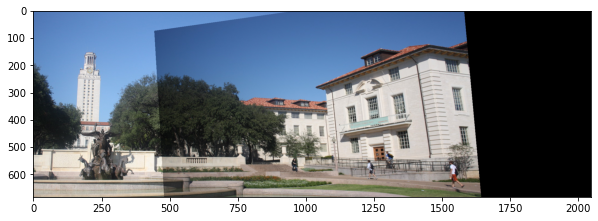

In [17]:
# The black part is a region of the stitched image that does not come from the two original images.
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/question_3_12.pdf', format='pdf', bbox_inches='tight')

#### **Answer 3.13**

Execute the cell below and copy the saved image on Overleaf for Question 3.13. The cell runs the image stitching function to stitch the two sample images together (assuming that they are in left to right order) without filtering out outlier correspondences using RANSAC. You should observe that without RANSAC, the stitching does not work properly, showing the importance of RANSAC in the image stitching pipeline. *Note:* This cell may take up to a few minutes to execute.

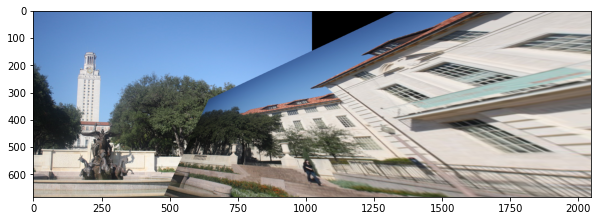

In [18]:
# The black part is a region of the stitched image that does not come from the two original images.
stitched_image = stitch_image(image1, image2, 2000, 0.6, 50, 6, 3, False)
stitched_plot = display_color(stitched_image / 255.0)
stitched_plot.savefig('Data/Solutions/question_3_13.pdf', format='pdf', bbox_inches='tight')

# Question 4

### Olympic Champion Using Homography

In this question, you will be making yourself the new World Swimming Champion using homography.

You are given the following image from the London 2012 Olympics. 

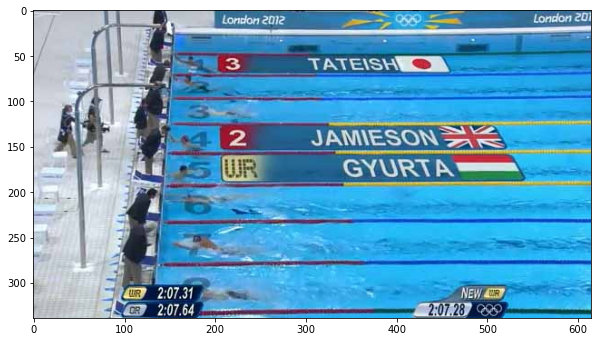

In [19]:
img = np.asarray(Image.open('Data/Problem_4/pool-vfx.jpg'))
_ = display_color(img/255.0)

You have to use homography to make yourself the new World Champion:

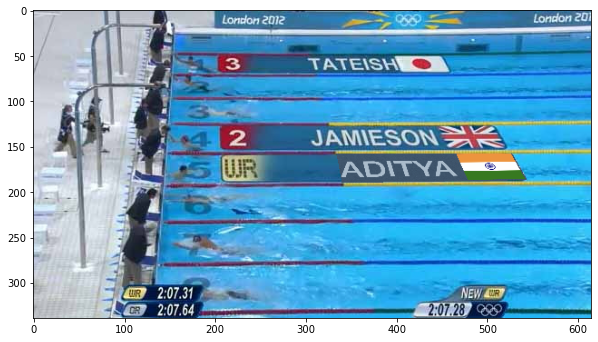

In [20]:
img_final = Image.open('Data/Problem_4/question_4.png')
display(img_final)

In the previous question, you used homography to stitch two images. You will use many functions from the previous question for this question. In the previous question, you used SIFT to compute the correspondences between the two images. Here you will estimate the corresponding points manually to construct the homography matrix and create the new image.

You will need two images for this question: (1) the pool image which we have provided, (2) an image with your name and country flag. To get an image with your name and flag, you are free to choose any method you want. In the example above, we used Keynote (on Mac) + Screenshot to get that image.

(102, 490, 3)


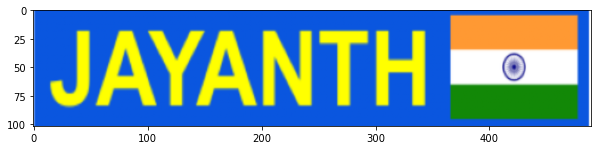

In [21]:
# Load your name+flag image here. You are free to choose any logo you want; we just provided a flag as an example.

name_img = np.asarray(Image.open('Data/Problem_4/name_image.png').convert('RGB'))
print(name_img.shape)
_ = display_color(name_img/255.0)

In the previous question, you used SIFT to compute the corresponding points. For this question, we have provided you with 4 points which should correspond to the 4 corners of your name+flag image.

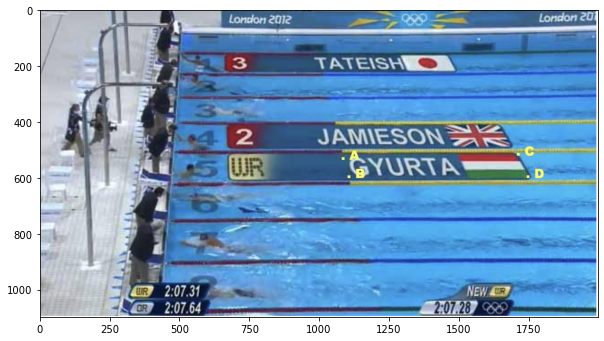

In [22]:
cp = np.asarray(Image.open('Data/Problem_4/Corresponding_points.png'))
_ = display_color(cp/255.0)

The $(x, y)$ coordinates for points $A, B, C, D$ in the above image, which will correspond to the 4 corners of your name+flag image, are provided below. For these $(x, y)$ coordinates, the positive x direction is along the right, the positive y direction is along the bottom, and the origin is the top left pixel of the image.

$(x,y)$ coordinates of the 4 points:
$A = (334, 158)$
$B = (340, 190)$
$C = (528, 157)$
$D = (545, 187)$

#### **Answer 4.1**

Fill in the values for the points corresponding to $A, B, C, D$ in your name+flag image. Copy the below cell on Overleaf for Question 4.1.

In [23]:
# Fill in the values for the corresponding points for your name+flag image.

A_1 = [0, 0]
B_1 = [0, 102]
C_1 = [490, 0]
D_1 = [490, 102]
correspondence = np.array([
                  ([334,158], A_1),
                  ([340,190], B_1),
                  ([528,157], C_1),
                  ([545,187], D_1),
])

Using the 4 correspondences, you can construct the homography matrix.

In [24]:
homography = compute_homography(correspondence)

Now, you will need to stitch the name+flag image into the original Olympic pool image. Complete the function ```stitch_image_given_H_new(pool_image, name_flag_image)``` for this task, which stitches the name+flag image into the original Olympic pool image. Copy paste your solution in the cell below on Overleaf for Question 4.2.

This function should be similar to the stitching function you wrote previously with minor differences: (1) Previously, since you had to stitch two images side by side, the output image had twice the number of columns as the original image. For this question, since you will be stitching the name+flag image inside the pool image, the output image will have the same number of columns as the input pool image. In other words the output will have the same dimension as `pool_image`. (2) If a pixel location in the stitched image is valid in `pool_image` and has a valid inverse-warped pixel location in `name_flag_image`, then you will use the pixel value from `name_flag_image` instead of averaging both images' pixel locations.

#### **Answer 4.2**

In [25]:
# Write your code in this cell.

def stitch_image_given_H_new(pool_image, name_flag_image, homography):
    m1, n1, _ = pool_image.shape
    m2, n2, _ = name_flag_image.shape
    image = np.zeros((m1, n1, 3), np.float32)
    stitched_image = np.zeros((m1, n1, 3), np.float32)
    for y in range(m1):
        for x in range(n1):
            x_transformed, y_transformed = apply_homography((x, y), homography)
            if x_transformed < 0 or y_transformed < 0 or x_transformed > n2 - 1 or y_transformed > m2 - 1:
                continue
            image[y][x] = (interpolate(name_flag_image, (y_transformed, x_transformed)))
    for y in range(m1):
        for x in range(n1):
            if not np.any(image[y][x]):
                stitched_image[y][x] = pool_image[y][x]
            else:
                stitched_image[y][x] = image[y][x]
    return stitched_image

#### **Answer 4.3**

Execute the cell below and copy the saved image on Overleaf for Question 4.3. The cell runs the new stitching function to stitch your name+flag image into the original Olympic pool image.

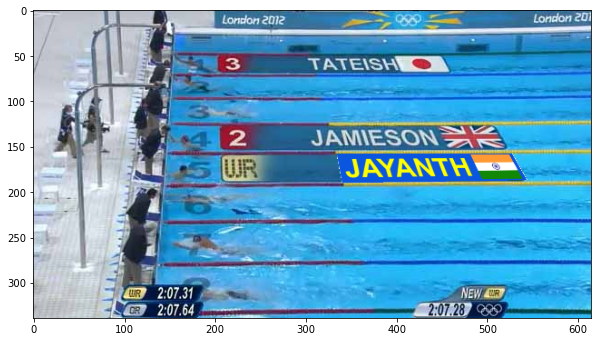

In [26]:
new_olympic_champion = stitch_image_given_H_new(img, name_img, homography)
plot = display_color(new_olympic_champion,True)
os.makedirs('Data/Solutions', exist_ok=True)
plot.savefig('Data/Solutions/question_4.png', format='png', bbox_inches='tight')

# Question 5

### Eight-Point Algorithm

In this question, you will use the eight-point algorithm to reconstruct 3D points associated with some correspondences between two images of the same scene. For this task, you will implement a pipeline with three broad steps:
1. Implement the eight-point algorithm to estimate the essential matrix.
2. Compute the translation and rotation between the cameras' coordinate frames using the essential matrix.
3. Reconstruct the 3D points by solving for their depths. Combining the depths with the 2D points will yield the reconstructed 3D points.

Load the correspondences. The correspondences are given as a list of tuples $((x_1, y_1), (x_2, y_2))$, where $(x_1, y_1)$ and $(x_2, y_2)$ are the corresponding points from the first and second image, respectively.

In [27]:
def format_correspondences(correspondences):
    formatted_corr = []
    for correspondence in correspondences:
        point1, point2 = correspondence[0:2], correspondence[2:]
        formatted_corr.append((point1, point2))
    return formatted_corr

In [28]:
correspondences = np.load('Data/Problem_5/correspondences.npy')
correspondences = format_correspondences(correspondences)

#### **Answer 5.1**

The first step for reconstructing the 3D points $X_1, X_2$ is to estimate the essential matrix using the eight-point algorithm. Complete the function ```compute_essential_matrix(correspondences)```, which returns the essential matrix given some correspondences using the algorithm in lecture 9. Copy paste your solution in the cell below on Overleaf for Question 5.1.

Assume that the essential matrix corresponds to rotating and translating the first image's camera frame to the second image's camera frame (i.e. $X_2=RX_1 + T$, where $R$ is the rotation matrix and $T$ is the translation vector). Enforce that the essential matrix $Q$ must be rank 2 by running SVD on it ($Q = U \Sigma V^T$), setting the smallest singular value of $Q$ to 0 to get a matrix $\Sigma'$ with the new singular values, and outputting the modified essential matrix $Q = U \Sigma' V^T$.

*Hint*: This process is similar to computing the homography between two images (question 3.4).

In [29]:
# Write your code in this cell.

def compute_essential_matrix(correspondences):
    A = []
    for i in range(len(correspondences)):
        x1 = np.append(correspondences[i][0], 1)
        x2 = np.append(correspondences[i][1], 1)
        A.append(np.kron(x2, x1))        
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape((3, 3))
    F = F / F[2][2]
    UF, SF, VtF = np.linalg.svd(F)
    SF[2] = 0
    sigma = SF[0] + SF[1] / 2
    SF[0] = sigma
    SF[1] = sigma
    Q = UF@ np.diag(SF) @ VtF
    Q = Q / Q[2][2]
    
    return Q

#### **Answer 5.2**

Now that you have computed the essential matrix, you can then compute the translation and rotation between the coordinate frames of both images' cameras. Complete the function ```compute_translation_rotation(essential_matrix)```, which returns the translation vector $T$, rotation matrix $R$, and $\hat{T}$ (the matrix associated with $T$) given the essential matrix $Q$. Copy paste your solution in the cell below on Overleaf for Question 5.2.

*Note:* Lecture 9 has a typo with the formula for the rotation matrix. The middle matrix in the formula should be transposed.

In [30]:
# Write your code in this cell.

def compute_translation_rotation(essential_matrix):
    UF, S, VtF = np.linalg.svd(essential_matrix)
    M = np.array(([0, -1, 0], [1, 0, 0], [0, 0, 1]))
    R = UF @ M @ VtF * 1
    T = UF @ M @ np.diag(S) @ np.transpose(UF) * 1
    t = np.array([T[2,1], T[0,2], T[1,0]])
    return t, R, T

#### **Answer 5.3**

You can sanity check the translation and rotation by checking that $\hat{T}$ is approximately skew-symmetric ($\hat{T}^T \approx -\hat{T}$, approximate due to numerical issues) and that the rotation matrix $R$ is orthogonal ($R^T=R^{-1}$); note that you don't check that $\det R = 1$, which may not hold due to numerical issues. Execute the cell below, which prints various useful quantities such as $T$, $R$, $\hat{T}$, $R^T$, $R^{-1}$ and copy the output on Overleaf for question 5.3.

In [31]:
essential_matrix = compute_essential_matrix(correspondences)
translation, rotation, t_hat = compute_translation_rotation(essential_matrix)
print("Translation vector: ", translation)
print("Rotation matrix: \n", rotation)
print("T_hat: \n", t_hat)
print("R^T: \n", np.transpose(rotation))
print("R^-1: \n", np.linalg.inv(rotation))

Translation vector:  [-18363.83082217   -493.09230538   3999.53058259]
Rotation matrix: 
 [[ 0.96765823 -0.01752971  0.25165504]
 [ 0.01634127  0.99984327  0.00681171]
 [-0.251735   -0.00247905  0.96779303]]
T_hat: 
 [[ 1.73742082e-13 -3.99953058e+03 -4.93092305e+02]
 [ 3.99953058e+03 -2.72844081e-12  1.83638308e+04]
 [ 4.93092305e+02 -1.83638308e+04  1.82183808e-12]]
R^T: 
 [[ 0.96765823  0.01634127 -0.251735  ]
 [-0.01752971  0.99984327 -0.00247905]
 [ 0.25165504  0.00681171  0.96779303]]
R^-1: 
 [[ 0.96765823  0.01634127 -0.251735  ]
 [-0.01752971  0.99984327 -0.00247905]
 [ 0.25165504  0.00681171  0.96779303]]


#### **Answer 5.4**

With the translation and rotation matrices, you can solve for the depths of the 3D points in the scene. Complete the function ```compute_depths(correspondences, translation, rotation)``` that computes the depths of the corresponding 3D points in the scene relative to both cameras given a list of 2D correspondences and the translation vector and rotation matrix from the first camera to the second camera. Copy paste your solution in the cell below on Overleaf for Question 5.4. *Hint*: The pseudoinverse may be useful.

In [32]:
# Write your code in this cell.

def compute_depths(correspondences, translation, rotation):
    A = []
    Z = []
    for i in range(len(correspondences)):
        x1 = np.append(correspondences[i][0], 1)
        x2 = np.append(correspondences[i][1], 1)
        A = np.array([-rotation.dot(x1), x2, np.ones(3)])
        Z.append(np.linalg.inv(A.T).dot(translation))
    return [z[0:2] for z in Z]

#### **Answer 5.5**

Using the depths of the 3D points, you can scale the 2D points, represented using homogeneous coordinates, to obtain the reconstructed 3D points. Complete the function ```reconstruct_3d(correspondences, depths)``` that reconstructs the corresponding 3D points relative to both cameras given 2D correspondences and the associated depths relative to the two cameras. The result should be returned as a list of correspondences of 3D points, where each correspondence is a tuple $(X_1, X_2)$ with $X_1$ and $X_2$ being the coordinates of the 3D point relative to the first and second images' cameras. Copy paste your solution in the cell below on Overleaf for Question 5.5.

In [33]:
# Write your code in this cell.

def reconstruct_3d(correspondences, depths):
    ret = []
    for i, corr in enumerate(correspondences):
        x1, x2 = correspondences[i]
        x1 = depths[i][0] * np.append(x1, 1)
        x2 = depths[i][1] * np.append(x2, 1)
        ret.append((x1, x2))
    return np.array(ret)

#### **Answer 5.6**

Now that you have implemented the 3D reconstruction, you can check that the results are consistent with the input 2D correspondences by reprojecting the 2D points in image 1 into image 2. This cell checks this consistency via the following steps:
1. Reconstruct the 3D points $X_1$ relative to the first camera
2. Transform $X_1$ into 3D points $X_{warp}$ relative to the second camera (using the translation vector $T$ and rotation matrix $R$)
3. Project $X_{warp}$ back into 2D points $x_{warp}$ and compute mean relative error between $x_{warp}$ and the input 2D points $x_2$ in the second image.

Execute the cell below and report the mean relative error you obtain below for Question 5.6; the mean relative error should be within a few percent.

In [34]:
essential_matrix = compute_essential_matrix(correspondences)
translation, rotation, _ = compute_translation_rotation(essential_matrix)
depths = compute_depths(correspondences, translation, rotation)
corr_3d = reconstruct_3d(correspondences, depths)
rel_errors = []
for (point1_2d, point2_2d), (point1_3d, point2_3d) in zip(correspondences, corr_3d):
    warped_point1_3d = np.matmul(rotation, point1_3d) + translation
    warped_point1_2d = warped_point1_3d / warped_point1_3d[2]
    rel_errors.append(np.linalg.norm((warped_point1_2d[:2] - point2_2d)) / np.linalg.norm(point2_2d))
print(np.mean(rel_errors))

0.0405805973529048
